In [1]:
print(__doc__)

# Code source adapted from: Jaques Grobler
# License: BSD 3 clause

import random
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
import os
import csv
import pprint
import time

pp = pprint.PrettyPrinter(indent=4)

Automatically created module for IPython interactive environment


In [152]:
def treat_dataset(dataset):
    vcut = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
    vcolor = {'D': 6, 'E': 5, 'F': 4, 'G': 3, 'H': 2, 'I': 1, 'J': 0}
    vclarity = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
    
    target = []
    new_data = []
    for row in dataset:
        # Modify string to number values
#         row["cut"] = vcut[row["cut"]]
#         row["color"] = vcolor[row["color"]]
#         row["clarity"] = vclarity[row["clarity"]]
        
        new_data.append([])
        nrow = new_data[len(new_data)-1]
        
        # Add X0 for ease of use
        nrow.append(1)
        
        # Create new values
        row["carat2"] = float(row["carat"])**2
        row["table2"] = float(row["table"])**2
        row["depth2"] = float(row["depth"])**2
        row["x2"] = float(row["x"])**2
        row["y2"] = float(row["y"])**2
        row["z2"] = float(row["z"])**2
        
        row["carat3"] = float(row["carat"])**3
        row["table3"] = float(row["table"])**3
        row["depth3"] = float(row["depth"])**3
        row["x3"] = float(row["x"])**3
        row["y3"] = float(row["y"])**3
        row["z3"] = float(row["z"])**3
        
        row["carat4"] = float(row["carat"])**4
        row["table4"] = float(row["table"])**4
        row["depth4"] = float(row["depth"])**4
        row["x4"] = float(row["x"])**4
        row["y4"] = float(row["y"])**4
        row["z4"] = float(row["z"])**4
        
        row["xyz"] = float(row["x"]) * float(row["y"]) * float(row["z"])
        
        # Normalize values
        nrow.append(((float(row["carat"]) - (0.2+5.01)/2)/((0.2+5.01))))
#         nrow.append((float(row["xyz"]) - ((10.74/2) * (58.9/2) * (31.8/2) ))/(10.74 * 58.9 * 31.8))
        
#         nrow.append((float(row["cut"]) - (4/2))/4)
#         nrow.append((float(row["color"]) - (6/2))/6)
#         nrow.append((float(row["clarity"]) - (7/2))/7)
        nrow.append((float(row["x"]) - (10.74/2))/(10.74))
        nrow.append((float(row["y"]) - (58.9/2))/(58.9))
        nrow.append((float(row["z"]) - (31.8/2))/(31.8))
        nrow.append((float(row["depth"]) - (43+79)/2)/(43+79))
        nrow.append((float(row["table"]) - (43+95)/2)/(43+95))
        
        nrow.append(((float(row["carat2"]) - (0.2+5.01)**2/2)/((0.2+5.01)**2)))
        nrow.append((float(row["x2"]) - (10.74**2/2))/(10.74**2))
        nrow.append((float(row["y2"]) - (58.9**2/2))/(58.9**2))
        nrow.append((float(row["z2"]) - (31.8**2/2))/(31.8**2))
        nrow.append((float(row["depth2"]) - (122)**2/2)/(122**2))
        nrow.append((float(row["table2"]) - (138)**2/2)/(138**2))
        
        nrow.append(((float(row["carat3"]) - (0.2+5.01)**3/2)/((0.2+5.01)**3)))
        nrow.append((float(row["x3"]) - (10.74**3/2))/(10.74**3))
        nrow.append((float(row["y3"]) - (58.9**3/2))/(58.9**3))
        nrow.append((float(row["z3"]) - (31.8**3/2))/(31.8**3))
        nrow.append((float(row["depth3"]) - (122)**3/2)/(122**3))
        nrow.append((float(row["table3"]) - (138)**3/2)/(138**3))
        
        nrow.append(((float(row["carat4"]) - (0.2+5.01)**4/2)/((0.2+5.01)**4)))
        nrow.append((float(row["x4"]) - (10.74**4/2))/(10.74**4))
        nrow.append((float(row["y4"]) - (58.9**4/2))/(58.9**4))
        nrow.append((float(row["z4"]) - (31.8**4/2))/(31.8**4))
        nrow.append((float(row["depth4"]) - (122)**4/2)/(122**4))
        nrow.append((float(row["table4"]) - (138)**4/2)/(138**4))
        
        # Add values for cut, color and clarity
        for k,v in vcolor.items():
            nrow.append(1 if row["color"]==k else 0)
        for k,v in vcut.items():
            nrow.append(1 if row["cut"]==k else 0)
        for k,v in vclarity.items():
            nrow.append(1 if row["clarity"]==k else 0)
        
        # Remove target element and insert into it's own list
        target.append(float(row["price"]))
    return new_data, target

In [153]:
# Read and treat training dataset
dataset_train = []
reader = csv.DictReader(open('diamonds-train.csv', 'r'))
for line in reader:
     dataset_train.append(line)

dataset_train, target_train = treat_dataset(dataset_train)

# Read and treat test dataset
dataset_test = []
reader = csv.DictReader(open('diamonds-test.csv', 'r'))
for line in reader:
     dataset_test.append(line)

dataset_test, target_test = treat_dataset(dataset_test)

# Auxilary vector for name to number mapping
ds_index = {"x0":0, "carat":1, "cut":2, "color":3, "clarity":4, "x":5, "y":6, "z":7, "depth":8, "table":9}

In [144]:
def calculate_cost_function(thetas, data, target, _lambda):
    m = len(data)
    s = 0
    
    # Regularization term
    reg = 0
    for t in range(len(data[0])):
        reg += thetas[t] * thetas[t]
    reg *= _lambda
        
    for index in range(len(data)):
        h = 0
        h += thetas[0]
        for k in range(1, len(data[index])):
            h += thetas[k] * data[index][k]
        s += (h - float(target[index]))*(h - float(target[index]))
    return (1/(2*m)) * (s + reg)

def calculate_hfunction(features, thetas):
    h = 0
    for f in range(len(thetas)):
        h += thetas[f] * features[f]
    return h

def init_thetas(data):
    if len(data) == 0:
        return []
    thetas = []
    for k in range(len(data[0])):
        thetas.append(0)
    return thetas

def get_predictions(data, thetas):
    res = []
    for row in range(len(data)):
        res.append(np.matmul([data[row]],np.column_stack([thetas]))[0,0])
        
    return res

def graph_add_scatter(x, y, c='black'):
    plt.scatter(x, y, color= c)

def graph_add_line(x, y, c='black'):
    plt.plot(x, y, color=c, linewidth=3)

def plot(name=""):
    plt.xticks()
    plt.yticks()
    
    if name!="":
        plt.savefig(name)
    plt.show()
    plt.close()

def current_time():
    return int(round(time.time() * 1000))

def choose_delete(args):
    i = random.randint(0, len(args)-1)
    elem = args[i]
    args.remove(i)
    return elem

In [145]:
#####################################
#                                   #
#    GRADIENT DESCENT ALGORITHM     #
#                                   #
#####################################

def gradient_descent(data, target, batch_size = 1, max_iterations = 100, stopCondition = 1e-04, learningRate = 1e-03, j_step=1000, _lambda = 0.01):

    thetas     = init_thetas(data)
    done       = False
    m          = len(data)
    iterations = 0

    # After j_step iterations, compute cost function
    costs       = []
    itr_numbers = []
    
    retryCount = 0
    retryMax = 1000

    startTime = int(round(time.time() * 1000))
    while(iterations < max_iterations and not done):

        # Step through the dataset in chuncks
        for row in range(0, len(data), batch_size):
            new_thetas = thetas.copy()
            
            # Update theta 0 
            s = 0
            for offset in range(batch_size):
                if row + offset >= m:
                    break
                h = calculate_hfunction(data[row+offset], thetas)
                s = (h - float(target[row+offset])) * data[row+offset][0]
                
            new_thetas[0] = thetas[0] - ((learningRate / batch_size) * s)

            # For each theta we do the following
            for k in range(1, len(thetas)):

                s = 0
                # We add every row of the dataset to the error calculation (Batch)
                for offset in range(batch_size):
                    if row + offset >= m:
                        break

                    h = calculate_hfunction(data[row+offset], thetas)

                    s += (h - float(target[row+offset])) * data[row+offset][k]

                # Updating the new thetas vector values
                new_thetas[k] = thetas[k] * (1 - _lambda * learningRate / batch_size) - (learningRate * (s / batch_size))

            if iterations % j_step == 0:
                cost = calculate_cost_function(thetas, data, target, _lambda)
                if len(costs)>0 and cost > costs[-1]:
                    learningRate /= 1.001
                    if retryCount < retryMax:
                        retryCount+=1
                    else:
                        iterations = max_iterations
                else:
                    retryCount = 0
                costs.append(cost)
                itr_numbers.append(iterations)
                
            iterations = iterations + 1
            if iterations >= max_iterations:
                break

            # If the change in value for new thetas is too small, we can stop iterating
            done = True
            for k in range(len(thetas)):
                done = abs(thetas[k] - new_thetas[k]) < stopCondition and done
            if done:
                break

            # Atualization of the values of the thetas
            thetas = new_thetas.copy()

    if iterations >= max_iterations:
        print("Stopped by number of iterations\n")
    if done:
        print("Stopped by convergence\n")
    endTime = int(round(time.time() * 1000))
    print("RunTime = ", (endTime - startTime)/1000, " seconds")
    return thetas, itr_numbers, costs

In [67]:
#####################################
#                                   #
#   MINI BATCH GRADIENT ALGORITHM   #
#                                   #
#####################################

max_iter=20000
b_size=1000
thetas_mbatch, itr_numbers, costs = gradient_descent(dataset_train, target_train, _lambda=0.0000005, stopCondition = 0.00000000001, learningRate=1e-02, max_iterations=max_iter, j_step=1000, batch_size=b_size)

Stopped by number of iterations

RunTime =  1770.979  seconds


Coefficients: 

[   0.30483778745341866,
    16850.855587871916,
    22538.952128863555,
    -2117.72791494708,
    -1332.7143766541792,
    232.36217971349734,
    -1035.700113471928,
    1806.3226157177028,
    2082.312792165431,
    2434.407045670163,
    2586.2736667785894,
    2761.9909783723047,
    1080.435522240187,
    2530.4973665766393,
    3313.28807428379,
    3246.265606530172,
    3043.8026767610813,
    3238.229102540849,
    2440.6545274050727,
    2972.1203193681804,
    3169.882517467331,
    2230.4219093812244,
    2473.7597190264933,
    1590.735662919703,
    -955.7331789500676,
    885.79054859793,
    2915.2624897100964]

Mean absolute error: 991.72

Final Cost: 1002188.59

50.51484500073774


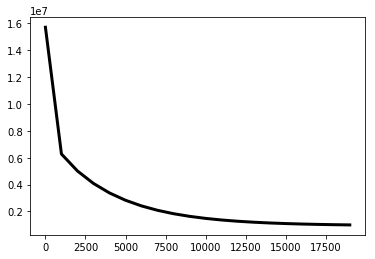

In [68]:
print("Coefficients: \n")
pp.pprint(thetas_mbatch)

print("\nMean absolute error: %.2f"
      % mean_absolute_error(target_train, get_predictions(dataset_train, thetas_mbatch)))

print("\nFinal Cost: %.2f\n"
      % costs[-1])

graph_add_line(itr_numbers, costs)
plot("MB_costitr_mitr"+str(max_iter)+"_b"+str(b_size))
# graph_add_scatter(get_feature(dataset_train, 'carat2'), target_train,c='gray')
# graph_add_scatter(get_feature(dataset_test, 'carat2'), target_test,c='black')
# graph_add_scatter(get_feature(dataset_test, 'carat2'), res, c='blue')
# plot()

In [18]:
#####################################
#                                   #
#     BATCH GRADIENT ALGORITHM      #
#                                   #
#####################################

max_iter=1000
thetas_batch, itr_numbers_batch, costs_batch = gradient_descent(dataset_train, target_train, _lambda=0.0000005, stopCondition = 0.00000001, batch_size=len(dataset_train), learningRate=1e-02, max_iterations=max_iter, j_step=100)

Stopped by number of iterations

RunTime =  4142.068  seconds


Coefficients: 

[   0.10926315102116331,
    1204.2814335353796,
    3502.637111847338,
    -1524.6649078471924,
    -1366.5096112001702,
    34.064640508831495,
    -379.7629529024573,
    1307.8183646540256,
    1113.6997999404616,
    1006.7432863184249,
    129.52375431168818,
    153.44091601704426,
    910.7769589347495,
    667.9503013831509,
    1017.5274957615767,
    1283.5547052342818,
    795.6521134246691,
    1734.3345000124016,
    458.8845671266193,
    -39.831636476118184,
    76.86944629105176,
    1035.179008767236,
    829.3914203998299,
    1064.2813776911369,
    145.56665936476267,
    1769.3418236659068,
    409.15528185574544]

Mean absolute error: 2554.09

Variance: 0.21

Final Cost: 6426353.60
144.63999932872832


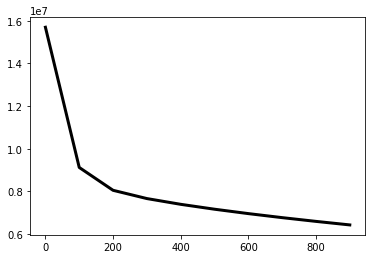

In [65]:
print("Coefficients: \n")
pp.pprint(thetas_batch)

print("\nMean absolute error: %.2f"
      % mean_absolute_error(target_train, get_predictions(dataset_train, thetas_batch)))

print("\nVariance: %.2f"
      % explained_variance_score(target_train, get_predictions(dataset_train, thetas_batch)))

print("\nFinal Cost: %.2f"
      % costs_batch[-1])

graph_add_line(itr_numbers_batch, costs_batch)
plot("B_costitr_mitr"+str(max_iter))
# graph_add_scatter(get_feature(dataset_train, 'carat2'), target_train,c='gray')
# graph_add_scatter(get_feature(dataset_test, 'carat2'), target_test,c='black')
# graph_add_scatter(get_feature(dataset_test, 'carat2'), res, c='blue')
# plot()

In [97]:
#####################################
#                                   #
#       STOCHASTIC ALGORITHM        #
#                                   #
#####################################
max_iter=2000000
thetas_sto, itr_numbers_sto, costs_sto = gradient_descent(dataset_train, target_train, _lambda=0.0000005, stopCondition = 0.00000000001, batch_size=1, learningRate=0.0001, max_iterations=max_iter, j_step=1000)

Stopped by number of iterations

RunTime =  639.16  seconds


Coefficients: 

[   6919.614246789303,
    18268.27967409149,
    20668.263201434103,
    952.5666313167582,
    1576.563256250494,
    144.2552941856384,
    -405.1226565259441,
    590.5389590086039,
    876.2728520207309,
    1238.1837953357615,
    1414.8848887170109,
    1596.4526483927193,
    -141.17919987552582,
    1343.9189511898758,
    1646.149795687641,
    1565.7630898861548,
    1370.3876581369404,
    1551.1294206490477,
    785.6429304291548,
    1951.102637736647,
    2182.7491851124205,
    1157.4720229520574,
    1420.8230151814084,
    516.2353911782466,
    -1974.9552651588135,
    -210.83309632833374,
    1876.4790041136812]

Mean absolute error: 986.05

Variance: 0.88

Final Cost: 958030.34


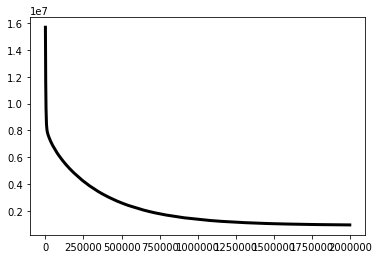

In [98]:
print("Coefficients: \n")
pp.pprint(thetas_sto)

print("\nMean absolute error: %.2f"
      % mean_absolute_error(target_train, get_predictions(dataset_train, thetas_sto)))

print("\nVariance: %.2f"
      % explained_variance_score(target_train, get_predictions(dataset_train, thetas_sto)))

print("\nFinal Cost: %.2f"
      % costs_sto[-1])

graph_add_line(itr_numbers_sto, costs_sto)
plot("S_costitr_mitr"+str(max_iter)+"_normalized")
# graph_add_scatter(get_feature(dataset_train, 'carat2'), target_train,c='gray')
# graph_add_scatter(get_feature(dataset_test, 'carat2'), target_test,c='black')
# graph_add_scatter(get_feature(dataset_test, 'carat2'), res, c='blue')
# plot()

In [154]:
#####################################
#                                   #
#          NORMAL EQUATION          #
#                                   #
#####################################

mat_target = []

for row in range(len(target_train)):
    mat_target.append([target_train[row]])

mat_train = np.matrix(dataset_train)
mat_train_T = mat_train.transpose()
mat_target = np.matrix(mat_target)

identity = np.identity(len(dataset_train[0]))
identity[0,0] = 0
errors = []
lambdas = []
_lambda = 0.01

startTime = int(round(time.time() * 1000))
for i in range(1):
    # thetas = (X^t * X + l * I)^(-1) * X^t * y
    thetas = (np.matmul(
                np.matmul(
                    inv(
                        np.add(
                            np.matmul(mat_train_T, mat_train), 
                            np.multiply(_lambda, identity))), 
                    mat_train_T), 
                mat_target))
    
    lambdas.append(_lambda)
    errors.append(mean_absolute_error(target_train, get_predictions(dataset_train, thetas)))
    _lambda -= 0.1

endTime = int(round(time.time() * 1000))
print("RunTime = ", (endTime - startTime)/1000, " seconds")

RunTime =  0.576  seconds


Coefficients: 

matrix([[-3.96421250e+03],
        [ 3.65979499e+04],
        [-9.63461360e+03],
        [ 4.04278302e+04],
        [ 4.09457054e+03],
        [ 1.99192598e+04],
        [ 3.92891166e+03],
        [ 6.17202888e+04],
        [-5.56086364e+04],
        [ 1.98499867e+04],
        [ 1.28841875e+04],
        [ 2.89789923e+02],
        [-2.52637340e+03],
        [-1.62548593e+05],
        [ 7.73606542e+04],
        [-2.18671419e+04],
        [ 5.71458344e+03],
        [-1.44817489e+04],
        [-5.10834827e+03],
        [ 6.07415818e+04],
        [-1.05293300e+04],
        [-3.45744563e+04],
        [ 1.26340500e+03],
        [-1.94073415e+04],
        [-4.76073918e+03],
        [-6.70103935e+02],
        [-1.82671598e+02],
        [ 3.43116031e+02],
        [ 6.35255759e+02],
        [ 8.50338708e+02],
        [-1.54163763e+03],
        [ 5.65702838e+02],
        [ 2.04619721e+02],
        [ 9.79946481e+01],
        [-1.63382249e+01],
        [ 1.06229726e+02],
        [-3.

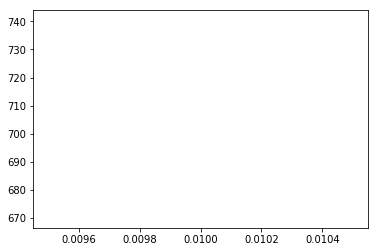

In [155]:
# error = 0
# for i in range(len(res)):
#     error += abs(target_test[i] - res[i]) / target_test[i]
# error /= len(res)
# print(error * 100)

print("Coefficients: \n")
pp.pprint(thetas)

print("\nMean absolute error: %.2f"
      % mean_absolute_error(target_train, get_predictions(dataset_train, thetas)))

print("Mean absolute error: %.2f"
      % mean_absolute_error(target_test, get_predictions(dataset_test, thetas)))

# print("\nFinal Cost: %2f"
#       % calculate_cost_function(thetas, dataset_train, target_train, _lambda))

graph_add_line(lambdas, errors)
plot()

In [13]:
#####################################
#                                   #
#     SKLEARN LINEAR REGRESSION     #
#                                   #
#####################################

# Create linear regression object
regr = linear_model.SGDRegressor(max_iter=200000, eta0=0.01, alpha=0.0000005)

startTime = int(round(time.time() * 1000))
# Train the model using the training sets
regr.fit(dataset_train, target_train)

endTime = int(round(time.time() * 1000))
print("RunTime = ", (endTime - startTime)/1000, " seconds")

# Make predictions using the validation set
y_pred = regr.predict(dataset_train)

RunTime =  3561.999  seconds


In [99]:
# The coefficients
coef = regr.intercept_.tolist() + regr.coef_.tolist()
print('Coefficients: \n', coef)
# The mean squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(target_train, y_pred))

print("\nFinal Cost: %2f"
      % regr.score(pd.DataFrame(dataset_train), target_train))

print(regr.n_iter_)

# # Plot outputs
# plt.scatter(get_feature(dataset_train, 'x'), target_train, color='gray')
# plt.scatter(get_feature(dataset_test, 'x'), target_test, color='black')
# plt.scatter(get_feature(dataset_test, 'x'), diabetes_y_pred, color='blue', linewidth=3)

# plt.xticks()
# plt.yticks()

# plt.savefig("sklearn_itr100000_lr0.01")

# plt.show()

Coefficients: 
 [10316.299306952524, 8612.548688496845, 58898.04483850373, -10779.885743675452, 648.526292443552, -3013.301434619566, -7804.953374757837, -4203.738029305771, 590.8822315529275, 1075.886930892958, 1574.6262731116149, 1851.3603774269827, 2060.671085923114, -322.9566218184843, 1782.078411393352, 1960.8501349617582, 1866.1442456878365, 1725.3872162878083, 1893.6304250460012, 1166.5366664859034, 2259.8200918947628, 2600.6771274465896, 1525.8644818677558, 1834.2426520896881, 921.7261393059335, -2687.448685021333, -48.89609372186114, 2206.56297461928]
Mean absolute error: 739.09

Final Cost: 0.919649
200000


In [106]:
#####################################
#                                   #
#    RESULTS FOR VALIDATION DATA    #
#                                   #
#####################################

print("scikit-learn: \n")

y_pred_val = regr.predict(dataset_test)

print("Mean absolute error: %.2f"
      % mean_absolute_error(target_test, y_pred_val))

print("\n\nNormal Equation: \n")


print("Mean absolute error: %.2f"
      % mean_absolute_error(target_test, get_predictions(dataset_test, thetas)))

print("\n\nStochastic: \n")


print("Mean absolute error: %.2f"
      % mean_absolute_error(target_test, get_predictions(dataset_test, thetas_sto)))

scikit-learn: 



ValueError: shapes (8091,25) and (27,) not aligned: 25 (dim 1) != 27 (dim 0)